# Load Raw Data And Compute MLDS

In [15]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='-1'

In [16]:
from glob import glob
import re
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import numpy as np
from utils import *

import tensorflow as tf
tf.config.set_visible_devices([],"GPU")
import piq
import torch

In [17]:
# Importamos las librerias
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax.scipy as jscipy
import scipy.io
import cv2

from tqdm.auto import tqdm

key = random.PRNGKey(0)

MLDS

In [18]:
def LL(x,psi,sig):
    def LL_func(x):
        #print(n)
        D =jnp.abs(psi[x[0]]-psi[x[1]])-jnp.abs(psi[x[2]]-psi[x[3]])
        #print(D)
        # Probabilidad de la elección
        pp = jscipy.stats.norm.cdf(D/sig)
        #print(pp)
        # Esto es para definir si es la probabilidad de elegir la de 0 (p) o la de 1 (1-p)
        aa = (x[4]-pp)
        bb = ((-1)**(1+x[4]))
        #print(aa,bb)
        return jnp.log(aa*bb)
        #print(LL)
    LLs = jax.vmap(LL_func)(x)
    return LLs.sum()

In [19]:
@jax.jit
def mlds_step(batch, psi, sig):
    # Derivadas
    # iii = np.random.permutation(exps.shape[0])[0:BS]
    DD = jax.grad(LL,1)(batch,psi,sig)
    DDs = jax.grad(LL,2)(batch,psi,sig)

    # Paso de descenso de gradiente
    # El primer psi y el último no se optimizan
    psi = psi.at[1:-1].set(psi[1:-1] + lr*DD[1:-1])
    sig = sig + lr*DDs
    #sig=jnp.clip(sig,0.05,0.5)
    # return psi, sig, LLs
    return psi, sig

Load answers

In [20]:
url = 'https://raw.githubusercontent.com/paudauo/BBDD_Affine_Transformations/refs/heads/main/answers.csv'
df = pd.read_csv(url,header=0)
print(df.head(5))

  gender age_group transformation  image_id_01  distortion_level_11  \
0    man     41-50       rotation            1                    2   
1    man     41-50       rotation            1                    3   
2    man     41-50       rotation            1                    4   
3    man     41-50       rotation            1                    6   
4    man     41-50       rotation            2                    3   

   distortion_level_12  distortion_level_21  distortion_level_22  \
0                    1                    4                    6   
1                    2                   10                    4   
2                    3                    6                    8   
3                    3                    1                    2   
4                    5                    9                    8   

   reaction_time_ms  answer  
0              3335       2  
1              3936       2  
2              5875       2  
3              3143       1  
4             

In [ ]:
# Choose the distortion and the image
im_ref = 1  # Reference Image (1,...,24)
transf = ['gaussian_noise'] #Distortion  (['rotation'] ['translation'] ['scale'] ['gaussian_noise'])

Nimages = 10 # Number of distortion levels
sig = 0.1
Np = 2000
BS = 20
lr = 0.0001
cada = 1
seed = random.PRNGKey(40)

# Load the specific experiment

BBDD = BBDD[BBDD['image_id_01'] == im_ref]
BBDD = BBDD[BBDD['transformation'].isin(transf)]

exp = BBDD[['distortion_level_11','distortion_level_12','distortion_level_21','distortion_level_22','answer']].values

exp = exp-1
exp = exp.astype('int')
exp = exp[exp[:,4]>-1]

In [33]:
exps =[]
for i in exp:
 a = list(map(int,i))
 exps.append(a)

exps=jnp.array(exps)
exps.shape, exps
# Inicializamos los pesos de forma lineal
psi = jnp.linspace(0,1,Nimages)
best_psi = jnp.linspace(0,1,Nimages)
best_sig = sig

#Buscamos los parámetros que maximizan el LL
# LLs = jnp.ones((Np,))*(-jnp.inf)
LLs = []

for ii in range(Np):
 batch_idxs = random.permutation(seed, jnp.arange(0,exps.shape[0]))[0:BS]
 seed, _ = random.split(seed)
 batch = exps[batch_idxs]
 psi, sig = mlds_step(batch, psi, sig)
 # LLs = LLs.at[ii].set(jax.jit(LL)(exps, psi, sig))
 LLs.append(jax.jit(LL)(exps, psi, sig))
 
 if jnp.mod(ii,cada)==0:
    print(ii,LLs[ii],jnp.round(psi,3),jnp.round(sig,3))

 if jnp.isnan(LLs[ii]):
    break

0 -499.66873 [0.         0.112      0.22800002 0.337      0.441      0.554
 0.66800004 0.777      0.88600004 1.        ] 0.12100001
1 -418.93607 [0.         0.10700001 0.23300001 0.342      0.44300002 0.55200005
 0.669      0.777      0.88100004 1.        ] 0.14500001
2 -394.54465 [0.         0.108      0.23200001 0.344      0.44700003 0.555
 0.67       0.776      0.878      1.        ] 0.156
3 -388.89563 [0.         0.10700001 0.231      0.347      0.44700003 0.554
 0.67       0.77500004 0.87900007 1.        ] 0.158
4 -372.47403 [0.         0.10600001 0.231      0.35000002 0.45000002 0.55600005
 0.671      0.77400005 0.87900007 1.        ] 0.16700001
5 -363.86996 [0.         0.10600001 0.23200001 0.35200003 0.45200002 0.55700004
 0.67       0.772      0.88000005 1.        ] 0.172
6 -356.88367 [0.         0.104      0.23300001 0.35300002 0.453      0.56
 0.67       0.771      0.87700003 1.        ] 0.17600001
7 -346.33606 [0.         0.105      0.23200001 0.35300002 0.45800003 0.562000

Text(0, 0.5, 'Response')

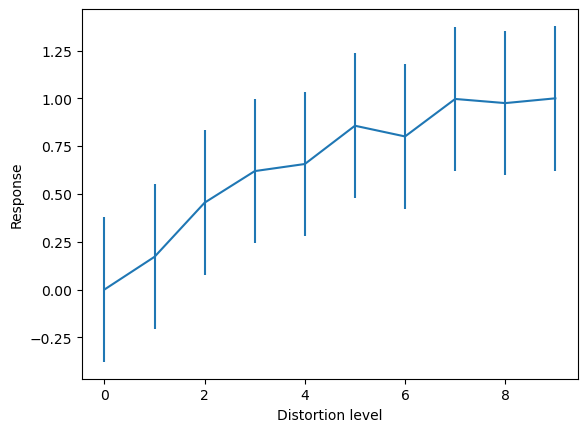

In [34]:
# Plot the computed MLSD response
plt.figure()
SIGS = sig*np.ones(*psi.shape)
xxx = np.linspace(0,psi.shape[0]-1,psi.shape[0])
plt.errorbar(xxx,psi,SIGS)

plt.xlabel('Distortion level')
plt.ylabel('Response')

Text(0, 0.5, 'Response')

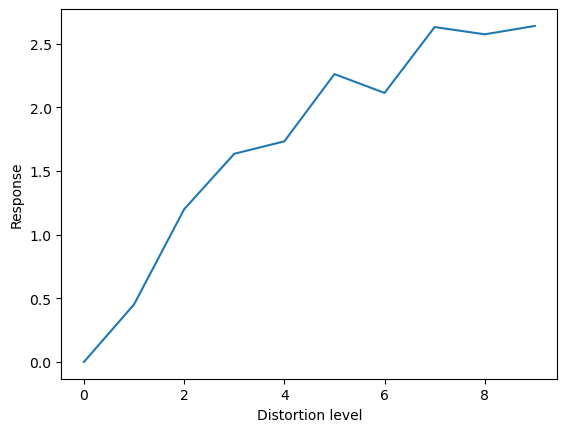

In [36]:
# Plot the computed MLSD response
plt.figure()
SIGS = sig*np.ones(*psi.shape)
xxx = np.linspace(0,psi.shape[0]-1,psi.shape[0])
plt.plot(xxx,psi/SIGS)

plt.xlabel('Distortion level')
plt.ylabel('Response')